# Blog Post: The ADAM Algorithm for Optimization
In this blog post, I will explore one more flavor of logistic regression - it's time for the adam optimizer. Since I've become so closely acquainted with LR, it will be interesting to compare all of these results amongst each other. Once I've completed the implementation, I will run a few experiments (as usual) to make sure everything is running smoothly. Then, I will test adam with a digits experiment, comparing the epochs and time it takes to converge against other types of logistic regression.

In [135]:
%load_ext autoreload
%autoreload 2
from LogisticRegression import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer
import torch
from matplotlib import pyplot as plt 
import numpy as np
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

In [137]:
# plots data and boundary decision based on w
# only works for dimension = 2

def plot_data_and_boundary(X, y, w, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the data
    targets = [0, 1]
    markers = ["o", ","]
    colors = ["red", "blue"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = colors[i], cmap = "BrBG", marker = markers[i])

    # Draw the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_values = torch.linspace(x_min, x_max, 100)
    y_values = -(w[0]*x_values + w[2])/w[1]
    ax.plot(x_values, y_values, color='black')

    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    plt.show()

Let's take a quick look at this data before we get started with some experiments.

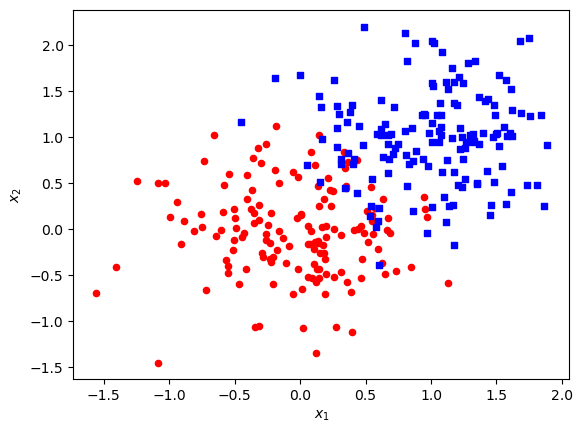

In [138]:
plot_data_and_boundary(X, y, [0, 0, 0])

# Experiment 1
To start with, let's check that this algorithm is actually working. In accordance with the parameters suggested by the paper as "good default settings" we'll set $\alpha = 0.001$, $\beta_1 = 0.9$, $\beta_2 = 0.999$, and $\epsilon = 10^{-8}$. 

After some messing around, the low value of alpha is requiring significantly more runtime, so I'm going to crank it up a bit.

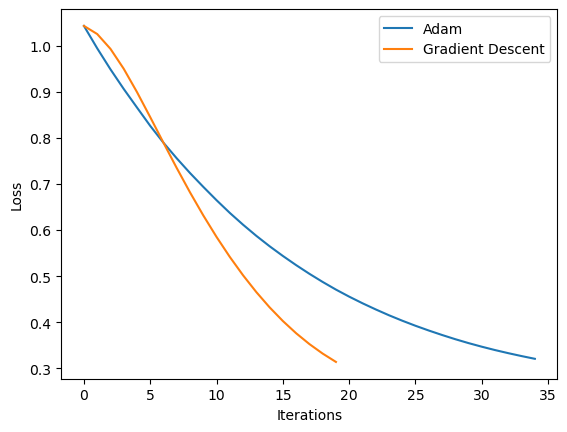

In [182]:
w = torch.linspace(-1, 1, X.shape[1])
w_prev = torch.linspace(-1, 1, X.shape[1])

adam = LogisticRegression(w) 
opt = AdamOptimizer(adam)

LR = LogisticRegression(w) 
opt_grad = GradientDescentOptimizer(LR, w, w_prev)

batch_size = 32
alpha = 0.1
beta_1 = 0.9
beta_2 = 0.999
epsilon = 0.1

losses_adam = []
losses_grad = []

start_adam = time.time()
while(torch.norm(adam.grad(X, y)) > epsilon):
    losses_adam.append(adam.loss(X, y))
    opt.step(X, y, batch_size, alpha, beta_1, beta_2, epsilon)
end_adam = time.time()

start_grad = time.time()
while(torch.norm(LR.grad(X, y)) > epsilon):
    losses_grad.append(LR.loss(X, y))
    opt_grad.step(X, y, alpha, beta = 0.9)
end_grad = time.time()

plt.plot(losses_adam, label = 'Adam')
plt.plot(losses_grad, label = 'Gradient Descent')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

Interestingly enough, it looks like adam is slower than gradient descent with momentum. This isn't quite what I was expecting, but I guess we'll just run with it for now. To be a bit more quantitative, adam converged in around 35 epochs while gradient descent only took about 20 epochs.

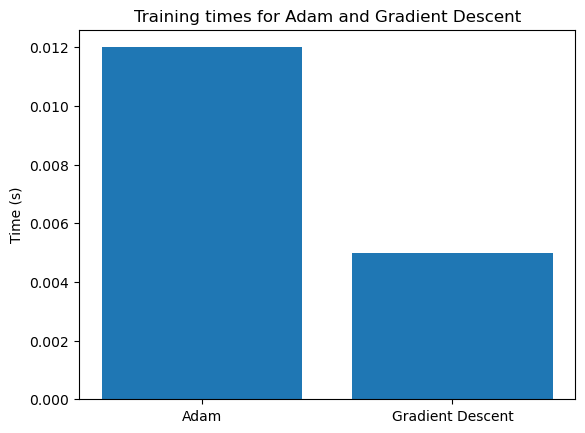

In [183]:
duration_adam = end_adam - start_adam
duration_grad = end_grad - start_grad

# Create the bar plot
labels = ['Adam', 'Gradient Descent']
times = [duration_adam, duration_grad]

plt.bar(labels, times)
plt.ylabel('Time (s)')
plt.title('Training times for Adam and Gradient Descent')
plt.show()

Adam also took a bit longer. Maybe my parameters need more tuning. Let's try some different ones.

2958 8825


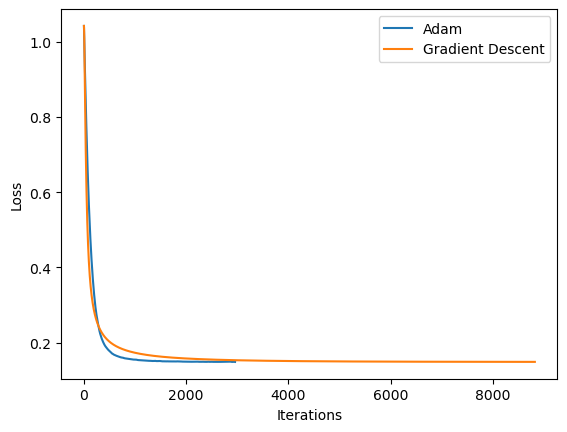

In [221]:
w = torch.linspace(-1, 1, X.shape[1])
w_prev = torch.linspace(-1, 1, X.shape[1])

adam = LogisticRegression(w) 
opt = AdamOptimizer(adam)

LR = LogisticRegression(w) 
opt_grad = GradientDescentOptimizer(LR, w, w_prev)

batch_size = 32
alpha = 0.01
beta_1 = 0.9
beta_2 = 0.9
epsilon = 0.001

losses_adam = []
losses_grad = []

start_adam = time.time()
count_adam = 0
while(torch.norm(adam.grad(X, y)) > epsilon):
    losses_adam.append(adam.loss(X, y))
    opt.step(X, y, batch_size, alpha, beta_1, beta_2, epsilon)
    count_adam += 1
end_adam = time.time()

start_grad = time.time()
count_grad = 0
while(torch.norm(LR.grad(X, y)) > epsilon):
    losses_grad.append(LR.loss(X, y))
    opt_grad.step(X, y, alpha, beta = 0.9)
    count_grad += 1
end_grad = time.time()

plt.plot(losses_adam, label = 'Adam')
plt.plot(losses_grad, label = 'Gradient Descent')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

print(str(count_adam) + " " + str(count_grad))

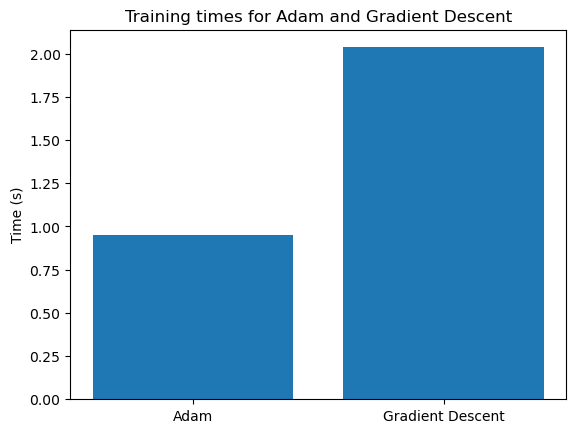

In [222]:
duration_adam = end_adam - start_adam
duration_grad = end_grad - start_grad

# Create the bar plot
labels = ['Adam', 'Gradient Descent']
times = [duration_adam, duration_grad]

plt.bar(labels, times)
plt.ylabel('Time (s)')
plt.title('Training times for Adam and Gradient Descent')
plt.show()

Ok wow. To be totally honest, I was not expecting that to work. I really thought grabbing the paper's suggested default values would solve all my problems. But hey, I'll take what I can get. Anyway, in actual qualitative terms, it looks like these parameters have adam converging in just under 1 second and only 2958 epochs while gradient descent takes around 2 seconds to converge in 8825 epochs.

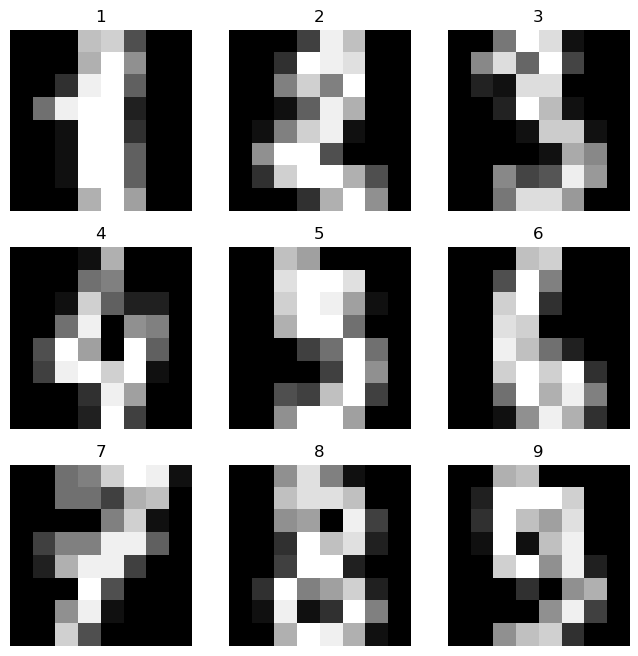

In [239]:
from sklearn.datasets import load_digits
import pandas as pd 

digits = load_digits()

df = pd.DataFrame(data = digits.data)
df['target'] = digits.target

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (8, 8))

for digit in range(1, 10):
    digit_data = df[df["target"] == digit].head(1)
    digit_image = digit_data.iloc[0, :-1].values.reshape(8, 8)
    ax = axes[(digit - 1) // 3, (digit - 1) % 3]
    ax.imshow(digit_image, cmap = "gray")
    ax.set_title(f"{digit}")
    ax.axis("off")

plt.show()


Since our logistic regression is only set up to do binary classification, lets choose just two digits. I'm going to go with 2 and 7, as the sample images above look pretty similar, and I want to see if the model can successfully overcome this challenge.

In [240]:
two_n_seven = df[df["target"].isin([1, 3])].copy()
two_n_seven.loc[:, "label"] = (two_n_seven["target"] == 1).astype(int)

In [241]:
X_27 = torch.tensor(two_n_seven.drop(columns = ["label", "target"]).values, dtype = float).float()
y_27 = torch.tensor(two_n_seven["label"].values, dtype = float).float()

Now that our data is in familiar X and y form, we can run AdamOptimizer and see how it goes.

In [245]:
w = torch.linspace(-1, 1, X_27.shape[1])
w_prev = torch.linspace(-1, 1, X_27.shape[1])

LR_grad = LogisticRegression(w)
opt_grad = GradientDescentOptimizer(LR_grad, w, w_prev)

losses_grad = []

start_grad = time.time()
count_grad = 0
while(torch.norm(LR_grad.grad(X_27, y_27)) > epsilon):
    losses_grad.append(LR_grad.loss(X_27, y_27))
    opt_grad.step(X_27, y_27, alpha = 0.05, beta = 0.9)
    count_grad += 1
end_grad = time.time()

print(count_grad)

12


24


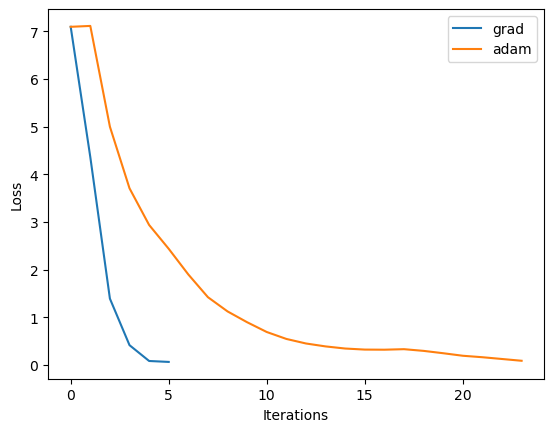

In [246]:
w = torch.linspace(-1, 1, X_27.shape[1])

adam = LogisticRegression(w) 
opt = AdamOptimizer(adam)

losses_adam = []

batch_size = 16
alpha = 0.05

start_adam = time.time()
count_adam = 0
while(torch.norm(adam.loss(X_27, y_27)) > epsilon):
    losses_adam.append(adam.loss(X_27, y_27))
    opt.step(X_27, y_27, batch_size, alpha, beta_1, beta_2, epsilon)
    count_adam += 1
end_adam = time.time()

plt.plot(losses_grad, label = "grad")
plt.plot(losses_adam, label = "adam")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

print(count_adam)

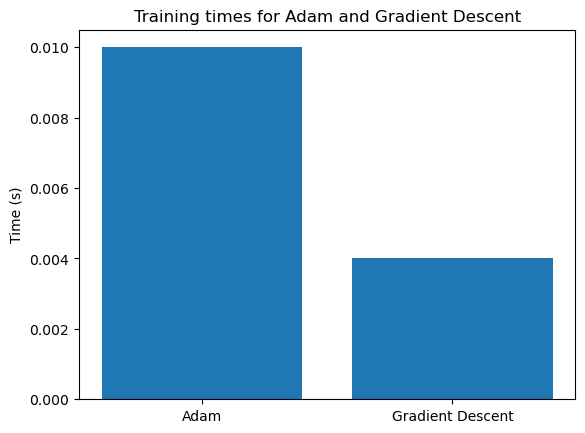

In [247]:
duration_adam = end_adam - start_adam
duration_grad = end_grad - start_grad

# Create the bar plot
labels = ['Adam', 'Gradient Descent']
times = [duration_adam, duration_grad]

plt.bar(labels, times)
plt.ylabel('Time (s)')
plt.title('Training times for Adam and Gradient Descent')
plt.show()

Aaaand we're back to gradient descent working better than adam. Maybe this problem doesn't play to adam's strengths.

Well, I tried my absolute best to speed run that. Probably not the best idea in the scheme of things, but I still think I took a fair bit away from it. The authors note many reasons that Adam should converge so efficiently. Among others, a few include the bias correction terms, the many parameters allowing further optimization, and the combination of two previously known efficient techniques. I did not observe that adam was highly efficient compared to my other implementations. I was able to get it to outcompete gradient descent with momentum by turning the momentum from 0.9 -> 0.5 in terms of both epochs to converge and time to converge, however this felt a bit like cheating. I hypothesize that I could have spent more time tuning my learning parameters, but gradient descent with momentum is so fast at a high momentum, and it felt a bit like cheating to turn this down just to let adam win. Overall I would say the implementation of adam in comparison to some of the other types of logistic regression was both smoother and bumpier. Smoother because at this point I have some experience implementing different types of logistic regression, and bumpier because I was reading a complex published research paper, and there was a lot more math involved. Overall, it was quite exciting, and I'd like to dig further into it when time permits.